- VITOR GONÇALVES REIS DA SILVA RA: 156670
- MARCOS VINICIUS GASPAROTO BAUAB RA: 156717

# NOTAS IMPORTANTES

- Link para nossa base de dados https://www.kaggle.com/datasets/prosperchuks/amazonsatelliteimages
- Utilzamos apenas a pasta train-jpg e train_v2.csv
- O COLAB estava sofrendo para acessar os endereços das imagens de forma rápida sem bugar, então para rodar as 10.000 imagens é necessário baixar as pastas no seu computador

In [ ]:
import pandas as pd
import zipfile
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
from sklearn.preprocessing import LabelEncoder
import os
import re
from sklearn.model_selection import KFold
import random
from PIL import Image
import sklearn.metrics as metrics
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import balanced_accuracy_score
from skimage.util import random_noise

In [ ]:
data_labels = pd.read_csv(r"C:\Users\vitor\OneDrive\Área de Trabalho\train_v2.csv\train_v2.csv")
classes = data_labels['tags'].unique()
print("Quantidade de classes antes da normalização: ", len(classes))

Quantidade de classes antes da normalização:  449


In [ ]:
data_labels.head(10)

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road
5,train_5,haze primary water
6,train_6,agriculture clear cultivation primary water
7,train_7,haze primary
8,train_8,agriculture clear cultivation primary
9,train_9,agriculture clear cultivation primary road


In [ ]:
# Estamos mapeando as classes, transformando todas as 449 em 2 floresta ou desmatado

def mapear_classes(tags):
    padrao = r"agriculture|mine|habitation|road" # Adicionei road também
    if re.search(padrao, tags):
        return 'desmatado'
    else:
        return 'floresta'

#estamos transformando todas as tags que aparecem cloudy em apenas cloudy para droparmos essas imagens pois são imagens que contém nuvens e não ajudam muito

def retirarImagensImprecisas(tags):
    padrao = r"cloudy|partly_cloudy"
    if re.search(padrao, tags):
        return 'cloudy'
    else:
        return tags

In [ ]:
data_labels["tags"]=data_labels["tags"].apply(retirarImagensImprecisas)
data_labels = data_labels.drop(data_labels[data_labels['tags'] == 'cloudy'].index)  #dropando imagens com nuvem
data_labels["tags"]=data_labels["tags"].apply(mapear_classes) # Floresta ou desmatado
print(data_labels)

        image_name       tags
0          train_0   floresta
1          train_1  desmatado
2          train_2   floresta
3          train_3   floresta
4          train_4  desmatado
...            ...        ...
40472  train_40472  desmatado
40473  train_40473  desmatado
40474  train_40474   floresta
40476  train_40476  desmatado
40477  train_40477  desmatado

[31129 rows x 2 columns]


In [ ]:
#data_labels= data_labels.drop(data_labels[data_labels['tags'] == 'floresta'].sample(n=6987, random_state=42).index)
class_counts = data_labels['tags'].value_counts()
print(class_counts)

tags
floresta     19058
desmatado    12071
Name: count, dtype: int64


In [ ]:
classes = data_labels['tags'].unique()
print("Quantidade de classes antes da normalização: ", len(classes))

Quantidade de classes antes da normalização:  2


In [ ]:
data_labels.head(10)

,image_name,tags
0,train_0,floresta
1,train_1,desmatado
2,train_2,floresta
3,train_3,floresta
4,train_4,desmatado
5,train_5,floresta
6,train_6,desmatado
7,train_7,floresta
8,train_8,desmatado
9,train_9,desmatado


In [ ]:
# Definir parâmetros da rede neural
input_shape = (224, 224, 3) #tamanho original das imagens
new_size=(112,112,3) # redução pela metade
num_classes = 2

In [ ]:
# Obter as classes e os nomes das imagens do arquivo CSV
# Aleatorização das imagens pegando do CSV o nome e a tag mas mantendo a ordenação

data_labels_aleatorio = data_labels.sample(n=1000, random_state=42)
classes = data_labels_aleatorio['tags'].tolist()
nomes_imagens= data_labels_aleatorio['image_name'].tolist()

In [ ]:
data_labels_copia = data_labels.copy()
data_labels_copia = data_labels_copia.drop(data_labels_aleatorio.index) #DROPA PARA NÃO PEGAR IMAGENS IGUAIS
data_labels_segundo_aleatorio = data_labels_copia.sample(n=1000, random_state=42)   # CONJUNTO DE TESTE FINAL NUNCA ANTES VISTO PELO MODELO
classes_test = data_labels_segundo_aleatorio ['tags'].tolist()
nomes_imagens_test= data_labels_segundo_aleatorio ['image_name'].tolist()

Conjunto de teste para o estudante

In [ ]:
X = []
y = []


# Diretório onde as imagens estão armazenadas
diretorio_imagens = r"C:\Users\vitor\OneDrive\Área de Trabalho\train-jpg"
for classe, nome_imagem in zip(classes, nomes_imagens):
    caminho_imagem = os.path.join(diretorio_imagens, nome_imagem) + ".jpg"
    print("Caminho da imagem:", caminho_imagem)
    print("Classe:", classe)

    # Carregar as imagens e classes para treinamento
    imagem = load_img(caminho_imagem, target_size=new_size[:2])
    imagem_array = img_to_array(imagem)
    X.append(imagem_array)
    y.append(classe)



Caminho da imagem: C:\Users\vitor\OneDrive\Área de Trabalho\train-jpg\train_5030.jpg
Classe: floresta
Caminho da imagem: C:\Users\vitor\OneDrive\Área de Trabalho\train-jpg\train_30807.jpg
Classe: floresta
Caminho da imagem: C:\Users\vitor\OneDrive\Área de Trabalho\train-jpg\train_23793.jpg
Classe: floresta
Caminho da imagem: C:\Users\vitor\OneDrive\Área de Trabalho\train-jpg\train_3850.jpg
Classe: desmatado
Caminho da imagem: C:\Users\vitor\OneDrive\Área de Trabalho\train-jpg\train_10674.jpg
Classe: floresta
Caminho da imagem: C:\Users\vitor\OneDrive\Área de Trabalho\train-jpg\train_10907.jpg
Classe: floresta
Caminho da imagem: C:\Users\vitor\OneDrive\Área de Trabalho\train-jpg\train_21975.jpg
Classe: floresta
Caminho da imagem: C:\Users\vitor\OneDrive\Área de Trabalho\train-jpg\train_28843.jpg
Classe: floresta
Caminho da imagem: C:\Users\vitor\OneDrive\Área de Trabalho\train-jpg\train_14844.jpg
Classe: desmatado
Caminho da imagem: C:\Users\vitor\OneDrive\Área de Trabalho\train-jpg\tra

Caminho da imagem: C:\Users\vitor\OneDrive\Área de Trabalho\train-jpg\train_8722.jpg
Classe: desmatado
Caminho da imagem: C:\Users\vitor\OneDrive\Área de Trabalho\train-jpg\train_11360.jpg
Classe: desmatado
Caminho da imagem: C:\Users\vitor\OneDrive\Área de Trabalho\train-jpg\train_12244.jpg
Classe: floresta
Caminho da imagem: C:\Users\vitor\OneDrive\Área de Trabalho\train-jpg\train_38112.jpg
Classe: floresta
Caminho da imagem: C:\Users\vitor\OneDrive\Área de Trabalho\train-jpg\train_28434.jpg
Classe: floresta
Caminho da imagem: C:\Users\vitor\OneDrive\Área de Trabalho\train-jpg\train_31971.jpg
Classe: floresta
Caminho da imagem: C:\Users\vitor\OneDrive\Área de Trabalho\train-jpg\train_31899.jpg
Classe: floresta
Caminho da imagem: C:\Users\vitor\OneDrive\Área de Trabalho\train-jpg\train_18272.jpg
Classe: desmatado
Caminho da imagem: C:\Users\vitor\OneDrive\Área de Trabalho\train-jpg\train_39454.jpg
Classe: desmatado
Caminho da imagem: C:\Users\vitor\OneDrive\Área de Trabalho\train-jpg\

Conjunto de teste para testar o professor no final


In [ ]:
Xtest_E=[]
ytest_E=[]

for classe, nome_imagem in zip(classes_test, nomes_imagens_test):
    caminho_imagem = os.path.join(diretorio_imagens, nome_imagem) + ".jpg"
    print("Caminho da imagem:", caminho_imagem)
    print("Classe:", classe)

    # Carregar as imagens e classes para treinamento
    imagem = load_img(caminho_imagem, target_size=new_size[:2])
    imagem_array = img_to_array(imagem)
    Xtest_E.append(imagem_array)
    ytest_E.append(classe)

Caminho da imagem: C:\Users\vitor\OneDrive\Área de Trabalho\train-jpg\train_21732.jpg
Classe: floresta
Caminho da imagem: C:\Users\vitor\OneDrive\Área de Trabalho\train-jpg\train_15122.jpg
Classe: floresta
Caminho da imagem: C:\Users\vitor\OneDrive\Área de Trabalho\train-jpg\train_29721.jpg
Classe: floresta
Caminho da imagem: C:\Users\vitor\OneDrive\Área de Trabalho\train-jpg\train_23396.jpg
Classe: desmatado
Caminho da imagem: C:\Users\vitor\OneDrive\Área de Trabalho\train-jpg\train_1805.jpg
Classe: floresta
Caminho da imagem: C:\Users\vitor\OneDrive\Área de Trabalho\train-jpg\train_39638.jpg
Classe: desmatado
Caminho da imagem: C:\Users\vitor\OneDrive\Área de Trabalho\train-jpg\train_33287.jpg
Classe: floresta
Caminho da imagem: C:\Users\vitor\OneDrive\Área de Trabalho\train-jpg\train_18369.jpg
Classe: desmatado
Caminho da imagem: C:\Users\vitor\OneDrive\Área de Trabalho\train-jpg\train_32512.jpg
Classe: floresta
Caminho da imagem: C:\Users\vitor\OneDrive\Área de Trabalho\train-jpg\t

Caminho da imagem: C:\Users\vitor\OneDrive\Área de Trabalho\train-jpg\train_12972.jpg
Classe: floresta
Caminho da imagem: C:\Users\vitor\OneDrive\Área de Trabalho\train-jpg\train_10984.jpg
Classe: desmatado
Caminho da imagem: C:\Users\vitor\OneDrive\Área de Trabalho\train-jpg\train_13806.jpg
Classe: desmatado
Caminho da imagem: C:\Users\vitor\OneDrive\Área de Trabalho\train-jpg\train_28332.jpg
Classe: desmatado
Caminho da imagem: C:\Users\vitor\OneDrive\Área de Trabalho\train-jpg\train_27465.jpg
Classe: floresta
Caminho da imagem: C:\Users\vitor\OneDrive\Área de Trabalho\train-jpg\train_24713.jpg
Classe: desmatado
Caminho da imagem: C:\Users\vitor\OneDrive\Área de Trabalho\train-jpg\train_24101.jpg
Classe: floresta
Caminho da imagem: C:\Users\vitor\OneDrive\Área de Trabalho\train-jpg\train_24284.jpg
Classe: floresta
Caminho da imagem: C:\Users\vitor\OneDrive\Área de Trabalho\train-jpg\train_28852.jpg
Classe: floresta
Caminho da imagem: C:\Users\vitor\OneDrive\Área de Trabalho\train-jpg

In [ ]:
# Pré-processamento dos dados
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
X = np.array(X) / 255.0
y = tf.keras.utils.to_categorical(y_encoded, num_classes)

y_encoded = label_encoder.fit_transform(ytest_E)
Xtest_E= np.array(Xtest_E) / 255.0
ytest_E = tf.keras.utils.to_categorical(y_encoded, num_classes)

noisy_images = []
for image in Xtest_E:
    noisy_image = random_noise(image, mode='speckle', var=0.03) # adicão de ruido
    noisy_images.append(noisy_image)

# Convertendo para um array numpy
noisy_images = np.array(noisy_images)



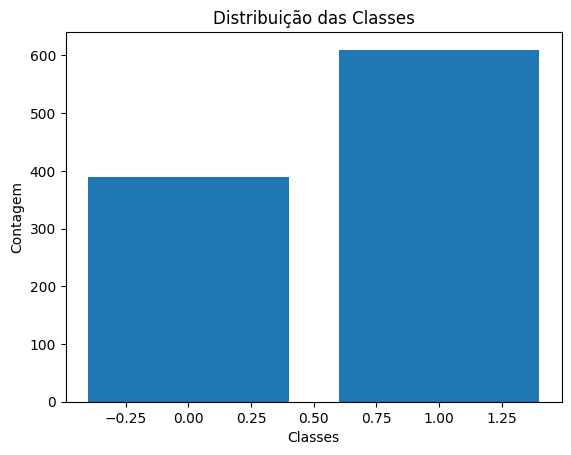

In [ ]:

unique_classes, class_counts = np.unique(y_encoded, return_counts=True)
plt.bar(unique_classes, class_counts)
plt.xlabel('Classes')
plt.ylabel('Contagem')
plt.title('Distribuição das Classes')
plt.show()

In [ ]:
# Criar modelo da CNN
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=new_size),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# Compilar o modelo
model.compile(optimizer='adam', loss='categorical_crossentropy')



Modelo Supervisionado treinado com todas as 1000 imagens, mesma estrutura


In [ ]:
# Criar modelo da CNN
model_supervisioned = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=new_size),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# Compilar o modelo
model_supervisioned.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])


In [ ]:
model_supervisioned.fit(X, y, epochs=5, batch_size=32)

Epoch 1/5
32/32 [==============================] - 15s 389ms/step - loss: 0.6504 - accuracy: 0.6290
Epoch 2/5
32/32 [==============================] - 12s 373ms/step - loss: 0.5892 - accuracy: 0.6870
Epoch 3/5
32/32 [==============================] - 13s 397ms/step - loss: 0.5474 - accuracy: 0.7220
Epoch 4/5
32/32 [==============================] - 10s 315ms/step - loss: 0.5020 - accuracy: 0.7530
Epoch 5/5
32/32 [==============================] - 8s 237ms/step - loss: 0.4905 - accuracy: 0.7520


# K Fold

- Para cada Fold são 4 conjuntos de teste, ou seja 80% dos dados, e 1 conjunto para treinamento, 20% dos dados. Eles são escolhidos de forma aleatória.

In [ ]:
confusion_matrices = []
losses = []  # Array para armazenar as losses de cada fold estudante
losses_E= [] # Array para armazenar as losses de cada fold professor


num_folds = 3  # Número desejado de folds

kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
for i, (train_index, test_index) in enumerate(kf.split(X), 1):
    print("Fold", i)
    X_train, X_test = X[train_index], X[test_index] # O conjunto menor chamado de test será usado para treino
    y_train, y_test = y[train_index], y[test_index]

    history = model.fit(X_test, y_test, epochs=5, batch_size=32) #Treinamos o modelo com o conjunto treino 80%
    fold_losses = history.history['loss']
    losses.append(fold_losses)

    predictions = model.predict(X_train)
    X_test = np.concatenate((X_test, X_train))# SOMA O CONJUNTO DE IMAGENS DE TESTE COM PSEUDOLABELS + DE TREINO PARA CRIAR UM NOVO CONJUNTO DE TREINAMENTO
    y_test = np.concatenate((y_test, predictions))


    print("\nTREINAMENTO DO MODELO ESTUDANTE")
    history=model.fit(X_test,y_test, epochs=5, batch_size=32)# TREINA O MESMO MODELO PORÈM COM ESSE NOVO CONJUNTO DE TESTE 100% dos dados porém com os valores de Y == predição
    fold_losses= history.history['loss']
    losses_E.append(fold_losses)

    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = np.argmax(y_train, axis=1)
    confusion_matrix = metrics.confusion_matrix(true_labels, predicted_labels)
    confusion_matrices.append(confusion_matrix)







Fold 1


Epoch 1/5
11/11 [==============================] - 3s 194ms/step - loss: 0.9341
Epoch 2/5
11/11 [==============================] - 2s 183ms/step - loss: 0.6907
Epoch 3/5
11/11 [==============================] - 2s 191ms/step - loss: 0.6723
Epoch 4/5
11/11 [==============================] - 2s 215ms/step - loss: 0.5915
Epoch 5/5
21/21 [==============================] - 1s 53ms/step

TREINAMENTO DO MODELO ESTUDANTE
Epoch 1/5
32/32 [==============================] - 8s 253ms/step - loss: 0.5869
Epoch 2/5
32/32 [==============================] - 8s 252ms/step - loss: 0.5621
Epoch 3/5
32/32 [==============================] - 8s 234ms/step - loss: 0.5485
Epoch 4/5
32/32 [==============================] - 10s 301ms/step - loss: 0.5547
Epoch 5/5
32/32 [==============================] - 9s 269ms/step - loss: 0.5531
Fold 2
Epoch 1/5
11/11 [==============================] - 3s 298ms/step - loss: 0.5329
Epoch 2/5
11/11 [==============================] - 3s 254ms/step - loss: 0.5433
Epoch 3/5
11/11

MATRIZ DE CONFUSÃO DA PREDIÇÃO FEITA PELO MODELO ESTUDANTE VS A VERDADE DOS DADOS

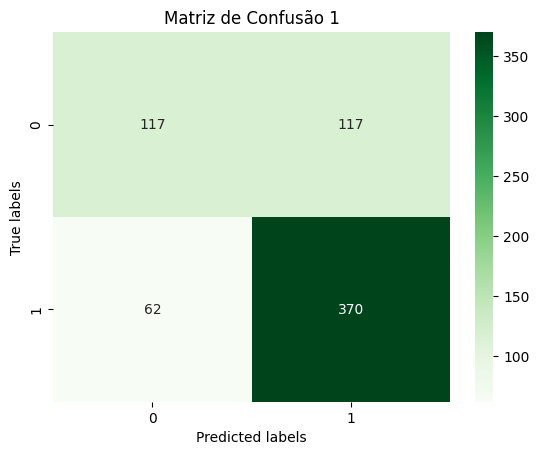

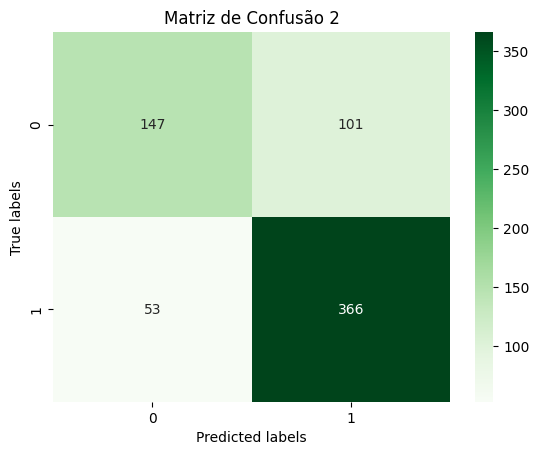

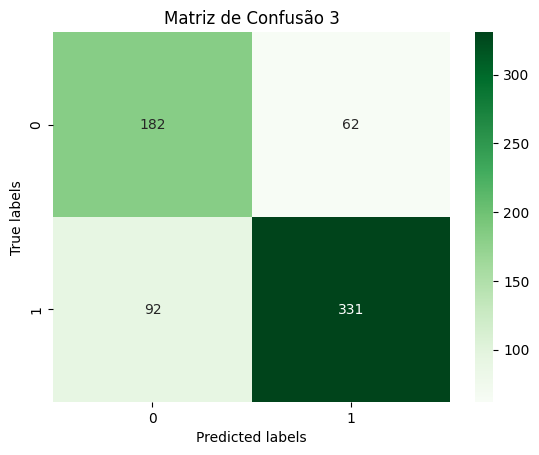

In [ ]:
for i, matrix in enumerate(confusion_matrices):
    plt.figure()
    sns.heatmap(matrix, annot=True, cmap='Greens', fmt='d')
    plt.title(f'Matriz de Confusão {i+1}')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show()

LOSS DO CONJUNTO DE TREINAMENTO DOS MODELOS ESTUDANTE VS PROFESSOR


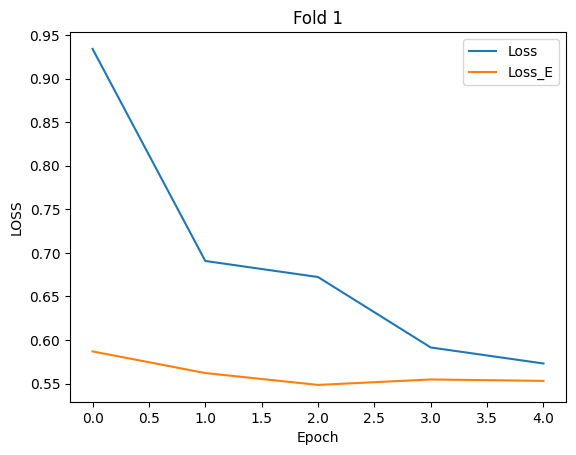

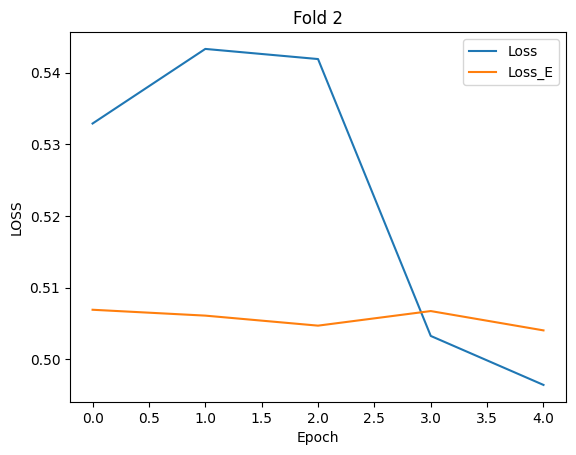

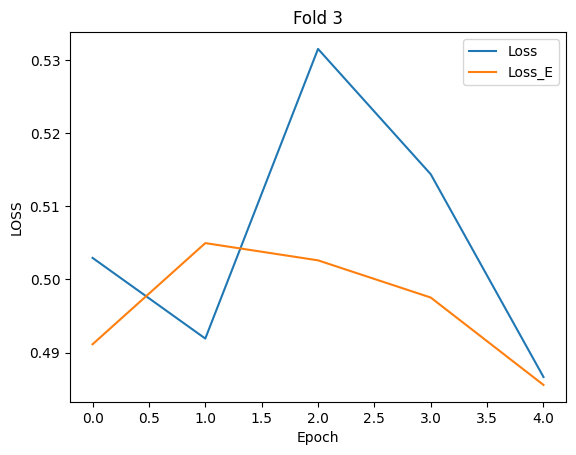

In [ ]:
for i in range(num_folds):
    # Obtém as accuracies do fold atual
    fold_loss_E = losses_E[i]
    fold_loss = losses[i]

    # Plotar gráfico para o fold atual
    plt.figure()
    line_loss, = plt.plot(fold_loss, label='Loss')
    line_loss_E, = plt.plot(fold_loss_E, label='Loss_E')
    plt.xlabel('Epoch')
    plt.ylabel('LOSS')
    plt.title('Fold {}'.format(i + 1))
    plt.legend(handles=[line_loss, line_loss_E])
    plt.show()

MOSTRANDO UM POUCO DE COMO MEU MODELO ESTA PREVENDO OS VALORES NUNCA VISTOS E SUA ACURÁCIA BALANCEADA

In [ ]:
predictions = model.predict(Xtest_E)
predicitons_ruido=model.predict(noisy_images)
predictions_supervisioned = model_supervisioned.predict(Xtest_E)

predicted_classes_ruido=np.argmax(predicitons_ruido, axis=1)
predicted_classes = np.argmax(predictions, axis=1)
predicted_classes_supervisioned=np.argmax(predictions_supervisioned, axis=1)

for predicted_class, true_value in zip(predicted_classes, y_encoded):
    print(f"Previsão: {predicted_class}")
    print(f"Valor Real: {true_value}")
    print()

32/32 [==============================] - 2s 50ms/step
Previsão: 1
Valor Real: 1

Previsão: 1
Valor Real: 1

Previsão: 1
Valor Real: 1

Previsão: 0
Valor Real: 0

Previsão: 1
Valor Real: 1

Previsão: 0
Valor Real: 0

Previsão: 1
Valor Real: 1

Previsão: 0
Valor Real: 0

Previsão: 0
Valor Real: 1

Previsão: 1
Valor Real: 1

Previsão: 1
Valor Real: 1

Previsão: 1
Valor Real: 1

Previsão: 1
Valor Real: 1

Previsão: 0
Valor Real: 0

Previsão: 0
Valor Real: 0

Previsão: 1
Valor Real: 1

Previsão: 1
Valor Real: 1

Previsão: 1
Valor Real: 1

Previsão: 0
Valor Real: 0

Previsão: 0
Valor Real: 0

Previsão: 0
Valor Real: 0

Previsão: 1
Valor Real: 1

Previsão: 0
Valor Real: 0

Previsão: 1
Valor Real: 1

Previsão: 0
Valor Real: 1

Previsão: 1
Valor Real: 1

Previsão: 0
Valor Real: 1

Previsão: 0
Valor Real: 0

Previsão: 1
Valor Real: 1

Previsão: 0
Valor Real: 0

Previsão: 0
Valor Real: 0

Previsão: 1
Valor Real: 1

Previsão: 0
Valor Real: 1

Previsão: 1
Valor Real: 1

Previsão: 1
Valor Real: 1

P

In [ ]:
balanced_accuracy = balanced_accuracy_score(y_encoded, predicted_classes)
print(f"Acurácia Balanceada: {balanced_accuracy}")
balanced_accuracy = balanced_accuracy_score(y_encoded, predicted_classes_ruido)
print(f"Acurácia Balanceada de imagens com ruido: {balanced_accuracy}")
balanced_accuracy = balanced_accuracy_score(y_encoded, predicted_classes_supervisioned)
print(f"Acurácia Balanceada de imagens do modelo Supervisionado: {balanced_accuracy}")


Acurácia Balanceada: 0.766036149642707
Acurácia Balanceada de imagens com ruido: 0.7772803699033207
Acurácia Balanceada de imagens do modelo Supervisionado: 0.7312526271542665


# Análise de resultados
Após o treinamento dessas imagens, utilizando 1 professor e 1 estudante, conseguimos acurácias muito interessantes, como 0.77 quando se fala do estudante treinado com imagens com ruído. Como resultados importantes, podemos concluir que o estudante treinado a partir de imagens com rótulos verdadeiros e rótulos feitos pelo professor possui uma base maior para aprender e assim consegue chegar a resultados que até mesmo ultrapassam a acurácia de um modelo supervisionado, como visto acima. Para melhorar ainda mais a acurácia do nosso modelo, adicionamos uma alteração nas imagens que fez com que o modelo não fosse muito específico somente ao conjunto de treino, portanto houve uma melhor generalização das predições, alcançando uma acurácia superior.

Em suma, vemos que a abordagem semi-supervisionada utilizando NST para classificação de imagens se mostra promissora, por mais que a quantidade de imagens com rótulos verdadeiros não seja grande.